Task 3: Let's implement a fit that finds the true values of $a$ and $b$ for the following function.

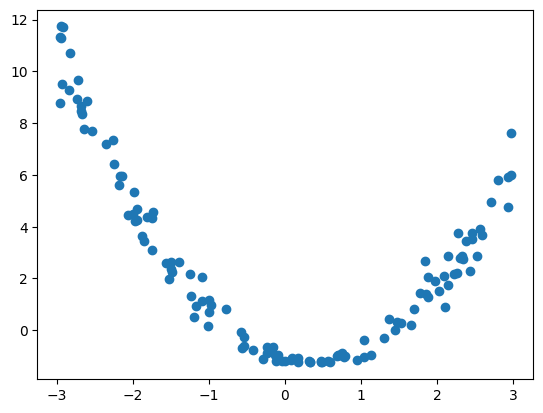

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


rng = jax.random.key(42)

true_a, true_b = 0.2, 1.1

# function that we want to fit
@jax.jit
def function(x, a, b):
  return b*x**2 - 4*a*x - b

# generate true data with some noise
def generate_data(rng):
  x_key, noise_key = jax.random.split(rng)

  xs = jax.random.uniform(x_key, (128, 1), minval=-3, maxval=3)
  noise = jax.random.normal(noise_key, (128, 1)) * 0.15

  ys = function(x=xs + noise, a=true_a, b=true_b)
  return xs, ys


# plot data
xs, ys = generate_data(rng=rng)
plt.scatter(xs, ys)

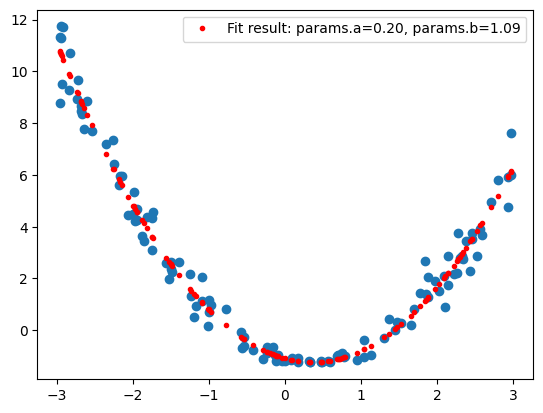

In [2]:
# Solution

from typing import NamedTuple


class Params(NamedTuple):
  a: jnp.ndarray
  b: jnp.ndarray


def init(rng) -> Params:
  """Returns the initial values of a & b."""
  a_key, b_key = jax.random.split(rng)
  a = jax.random.normal(a_key, ())
  b = jax.random.normal(b_key, ())
  return Params(a, b)


def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = function(x=x, a=params.a, b=params.b)
  return jnp.mean((pred - y) ** 2)


@jax.jit
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
  """Performs one gradient descent update step on params using the given data. (~SGD)"""
  grads = jax.grad(loss)(params, x, y)

  def step(param, grad):
    return param - 0.005 * grad  # 0.005 := learning rate

  updated_params = jax.tree.map(step, params, grads)
  return updated_params


# run the fit
params = init(rng)
for _ in range(500):
  params = update(params, xs, ys)


plt.scatter(xs, ys)
pred_ys = function(x=xs, a=params.a, b=params.b)
plt.plot(xs, pred_ys, ".", c='red', label=f'Fit result: {params.a=:.2f}, {params.b=:.2f}')
plt.legend()

**Bonus task:** train a neural network that learn the underlying function of this dataset.

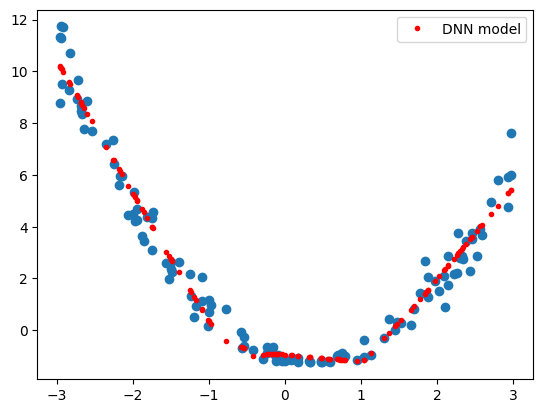

In [3]:
# Solution

from functools import partial
from typing import TypeAlias



class LayerParam(NamedTuple):
  W: jnp.ndarray
  b: jnp.ndarray


NetworkParams: TypeAlias = list[LayerParam]


def init(rng, in_size, out_size) -> LayerParam:
  """Returns the initial values of W & b."""
  W_key, b_key = jax.random.split(rng)
  W = jax.random.normal(W_key, (out_size, in_size))
  b = jax.random.normal(b_key, (out_size,))
  return LayerParam(W, b)


@partial(jax.vmap, in_axes=(None, 0))  # vectorize along x
def model(network_params: NetworkParams, x: jnp.ndarray) -> jnp.ndarray:
  """Simple neural network"""
  out = x
  for layer_params in network_params[:-1]:
    # dense layer
    out = layer_params.W @ out + layer_params.b
    # activation
    out = jax.nn.relu(out)
  # last layer has no actvation for a regression
  out = network_params[-1].W @ out + network_params[-1].b
  return out


def loss(network_params: NetworkParams, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = model(network_params, x)
  return jnp.mean((pred - y) ** 2)


@jax.jit
def update(network_params: NetworkParams, x: jnp.ndarray, y: jnp.ndarray) -> NetworkParams:
  """Performs one gradient descent update step on params using the given data. (~SGD)"""
  grads = jax.grad(loss)(network_params, x, y)

  def step(param, grad):
    return param - 0.005 * grad  # 0.005 := learning rate

  updated_network_params = jax.tree.map(step, network_params, grads)
  return updated_network_params


# Initialize network parameters for 3 layers
network_params = []
rng = jax.random.key(42)
layer_rngs = jax.random.split(rng, 3)
# layer 1:
network_params.append(init(layer_rngs[0], in_size=1, out_size=10))
# layer 2:
network_params.append(init(layer_rngs[1], in_size=10, out_size=10))
# layer 3:
network_params.append(init(layer_rngs[2], in_size=10, out_size=1))

# Run the training
for _ in range(500):
  network_params = update(network_params, xs, ys)


plt.scatter(xs, ys)
pred_ys = model(network_params, xs)
plt.plot(xs, pred_ys, ".", c='red', label='DNN model')
plt.legend()